# Fake Face Detection

## Step I : Importing Required Libraries

First, we import necessary libraries for data handling, feature extraction, model training, and evaluation.
A few most important libraries are to be included from scikit-learn.


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

## Step 2: Load and Preprocess the Data

We'll load the images from the dataset directory, convert them to grayscale, resize them for uniformity, and then create feature matrices and labels. And image paths are also stored for the future usage.

In [ ]:
def load_images_from_folder(folder):
    images = []
    labels = []
    image_paths = []
    for subdir, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith(('png', 'jpg', 'jpeg')):
                filepath = os.path.join(subdir, file)
                image_paths.append(filepath)# Labeling images based on folder name (e.g., 'real' or 'fake')
                label = os.path.basename(subdir)
                # Load the image and preprocess
                image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
                image = cv2.resize(image, (128, 128))  # Resize for uniformity
                images.append(image)
                labels.append(label)
    return np.array(images), np.array(labels), image_paths

# Load images from real and fake folders (update paths as per your setup)
X, y, image_paths = load_images_from_folder('/content/drive/MyDrive/pics/real_and_fake_face_detection/real_and_fake_face/')

## Step 3 : EDA

We tried doing Exploratory Data Analysis [EDA] by calculating the file size distribution, image dimensions and number of class images and labels.

In [ ]:
def image_stats(image_paths):
  dimensions=[]
  file_sizes=[]
  for i in image_paths:
    image=plt.imread(i)
    dimensions.append(image.shape[:2])
    file_sizes.append(os.path.getsize(i))
  return dimensions,file_sizes

dimensions, file_sizes = image_stats(image_paths)

In [ ]:
file_sizes=[x//1024 for x in file_sizes]

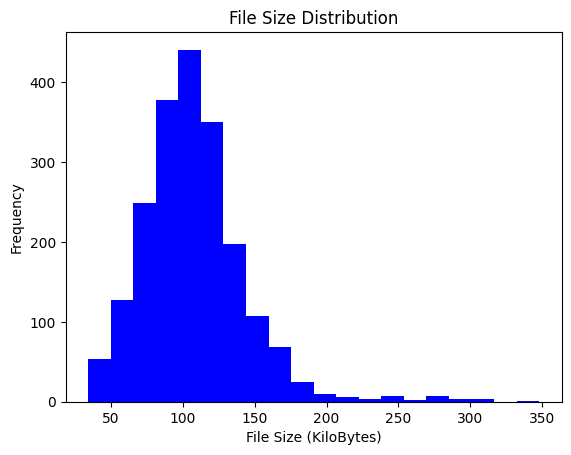

In [ ]:
# Plot file size distribution
plt.hist(file_sizes, bins=20, color='blue')
plt.title("File Size Distribution")
plt.xlabel("File Size (KiloBytes)")
plt.ylabel("Frequency")
plt.show()

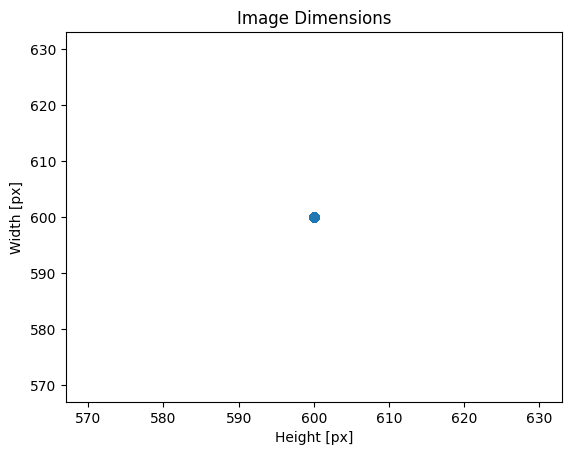

In [ ]:
# Plot image dimensions distribution
height, width = zip(*dimensions)
plt.scatter(height, width)
plt.title("Image Dimensions")
plt.xlabel("Height [px]")
plt.ylabel("Width [px]")
plt.show()

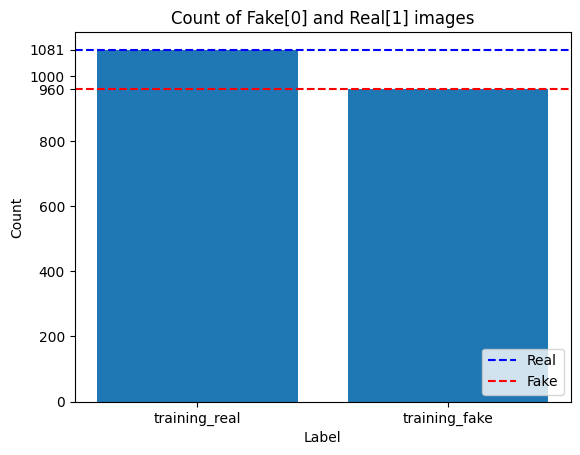

In [ ]:
df = pd.DataFrame({'Paths': image_paths, 'Real':y})

value_count = df.value_counts('Real')
fig,ax=plt.subplots()
bar=ax.bar(value_count.index, value_count.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count of Fake[0] and Real[1] images')
plt.xticks([0,1])
plt.yticks([0,200,400,600,800,960,1000,1081])
ax.axhline(bar[0].get_height(), linestyle='--', label='Real', color='blue')
ax.axhline(bar[1].get_height(), linestyle='--', label='Fake', color='red')
ax.legend(loc="lower right")
plt.show()

## Step 4: Label Encoding

We encode our labels from string format ('real'/'fake') to integers using `LabelEncoder`.

In [ ]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

## Step 5: Splitting the Dataset

We'll split our data into training and test sets using an 80-20 split.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=60)

## Step 6 : Denoising, Performing Local Binary Pattern (LBP) and Histograms of Oriented Gradients (HOG) Feature Extraction

We have first converted the training and testing images into denoised images, and then they are each converted into LBP features and HOG features to represent textures and improve classification. Both the features are then stacked on one top of the other, and the combined dataset is used.

In [ ]:
def denoise_images(images):
    return np.array([cv2.GaussianBlur(img, (3, 3), 0) for img in images])

X_train = denoise_images(X_train)
X_test= denoise_images(X_test)

In [ ]:
def local_binary_pattern(image):
    radius = 1  # Radius for LBP
    n_points = 8 * radius  # Number of points
    lbp = cv2.calcHist([image], [0], None, [256], [0, 256])  # Simplified
    return lbp.flatten()

# Extract LBP features for each image
X_train_features = np.array([local_binary_pattern(img) for img in X_train])
X_test_features = np.array([local_binary_pattern(img) for img in X_test])

In [ ]:
from skimage.feature import hog

def extract_hog_features(images):
    hog_features = []
    for image in images:
        # Compute HOG features
        features, _ = hog(image,
                          orientations=9,
                          pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2),
                          block_norm='L2-Hys',
                          visualize=True,
                          )
        hog_features.append(features)
    return np.array(hog_features)

# Extract HOG features
X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

In [ ]:
# Combine feature arrays (ensure they have compatible shapes)
X_train_combined = np.hstack((X_train_features, X_train_hog))
X_test_combined = np.hstack((X_test_features, X_test_hog))
# Normalize the combined features (optional, but recommended)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_combined = scaler.fit_transform(X_train_combined)
X_test_combined = scaler.fit_transform(X_test_combined)

## Step 7: Training and Testing Standard Machine Learning Models

We train, test and fit and evaluate models such as Logistic Regression, Random Forest Classifier, KNN Classifier, Support Vector Machines (SVM). We'll then compare their performance[accuracy, precision, recall, F1 Score and confusion matrix].

### 1. Logistic Regression

As we observe, the LR model performs quite fine and we get an accuracy score of around 60%.

In [ ]:
# Train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_combined, y_train)

# Predict and evaluate
y_pred_lr = lr_model.predict(X_test_combined)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))
print(accuracy_score(y_test, y_pred_lr))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.59      0.60       210
           1       0.59      0.62      0.60       199

    accuracy                           0.60       409
   macro avg       0.60      0.60      0.60       409
weighted avg       0.60      0.60      0.60       409

0.6014669926650367


### 2. Random Forest Classifier

Similarly, we observe that the Random Forest Classifier is also a good MLM and it provides an accuracy score of 62%.

In [ ]:
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=150)
rf_model.fit(X_train_combined, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test_combined)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print(accuracy_score(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.47      0.56       210
           1       0.58      0.79      0.67       199

    accuracy                           0.62       409
   macro avg       0.64      0.63      0.62       409
weighted avg       0.64      0.62      0.61       409

0.6234718826405868


### 3. KNN Classifier

An average accuracy of 62% is achieved by KNN Classifier which is very similar to that Random Forest Classifier.

In [ ]:
# Train k-Nearest Neighbors model
knn_model = KNeighborsClassifier(n_neighbors=15)  # You can tune 'n_neighbors' for better performance
knn_model.fit(X_train_combined, y_train)

# Predict on the validation set
y_pred_knn = knn_model.predict(X_test_combined)

# Evaluate performance
print("kNN Classification Report:")
print(classification_report(y_test, y_pred_knn))
print(accuracy_score(y_test, y_pred_knn))

kNN Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.66      0.64       210
           1       0.62      0.58      0.60       199

    accuracy                           0.62       409
   macro avg       0.62      0.62      0.62       409
weighted avg       0.62      0.62      0.62       409

0.6234718826405868


### 4. Support Vector Machine (SVM)

Of all the standard MLMs, we notice that the Support Vector Machine (SVM) outperforms other models by a small margin. It provides a decent accuracy score of 63%.

In [ ]:
# Train SVM model
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train_combined, y_train)

# Predict and evaluate
y_pred_svm = svm_model.predict(X_test_combined)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))
print(accuracy_score(y_test, y_pred_svm))

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.51      0.59       210
           1       0.59      0.75      0.66       199

    accuracy                           0.63       409
   macro avg       0.64      0.63      0.62       409
weighted avg       0.64      0.63      0.62       409

0.628361858190709


## Step 8: Comparing Model Performance

We'll compare the models using common metrics: accuracy, precision, recall, and F1 score.

In [ ]:
# Evaluate performance on test set for final comparison
models = {'Logistic Regression': lr_model,
          'Random Forest': rf_model,
          'KNN':knn_model,
          'SVM': svm_model
          }

for name, model in models.items():
    y_test_pred = model.predict(X_test_combined)
    print(" ")
    print(f"Performance of {name} on Test Set:")
    print("Accuracy:", accuracy_score(y_test, y_test_pred))
    print("Precision:", precision_score(y_test, y_test_pred))
    print("Recall:", recall_score(y_test, y_test_pred))
    print("F1 Score:", f1_score(y_test, y_test_pred))
    print(confusion_matrix(y_test, y_test_pred))
    print(" ")
    print("-" * 50)

 
Performance of Logistic Regression on Test Set:
Accuracy: 0.6014669926650367
Precision: 0.5857142857142857
Recall: 0.6180904522613065
F1 Score: 0.6014669926650367
[[123  87]
 [ 76 123]]
 
--------------------------------------------------
 
Performance of Random Forest on Test Set:
Accuracy: 0.6234718826405868
Precision: 0.5836431226765799
Recall: 0.7889447236180904
F1 Score: 0.6709401709401709
[[ 98 112]
 [ 42 157]]
 
--------------------------------------------------
 
Performance of KNN on Test Set:
Accuracy: 0.6234718826405868
Precision: 0.6203208556149733
Recall: 0.5829145728643216
F1 Score: 0.6010362694300518
[[139  71]
 [ 83 116]]
 
--------------------------------------------------
 
Performance of SVM on Test Set:
Accuracy: 0.628361858190709
Precision: 0.5936254980079682
Recall: 0.7487437185929648
F1 Score: 0.6622222222222223
[[108 102]
 [ 50 149]]
 
--------------------------------------------------


### Explanation

1. **Data Preprocessing**: Images are resized and converted to grayscale for uniformity and simplicity.
2. **LBP Feature Extraction**: We extract texture-based features, useful for distinguishing between real and fake images.
3. **Model Training**: Four common ML models (Logistic Regression, SVM, Random Forest, K-Neighbours Classifier) are trained and evaluated above.
4. **Evaluation Metrics**: We use metrics like accuracy, precision, recall, and F1-score to assess model performance.

<ipython-input-40-3603f74a3641>:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(sorted_labels, rotation=45, ha='right')
<ipython-input-40-3603f74a3641>:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(sorted_labels, rotation=45, ha='right')
<ipython-input-40-3603f74a3641>:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(sorted_labels, rotation=45, ha='right')
<ipython-input-40-3603f74a3641>:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(sorted_labels, rotation=45, ha='right')


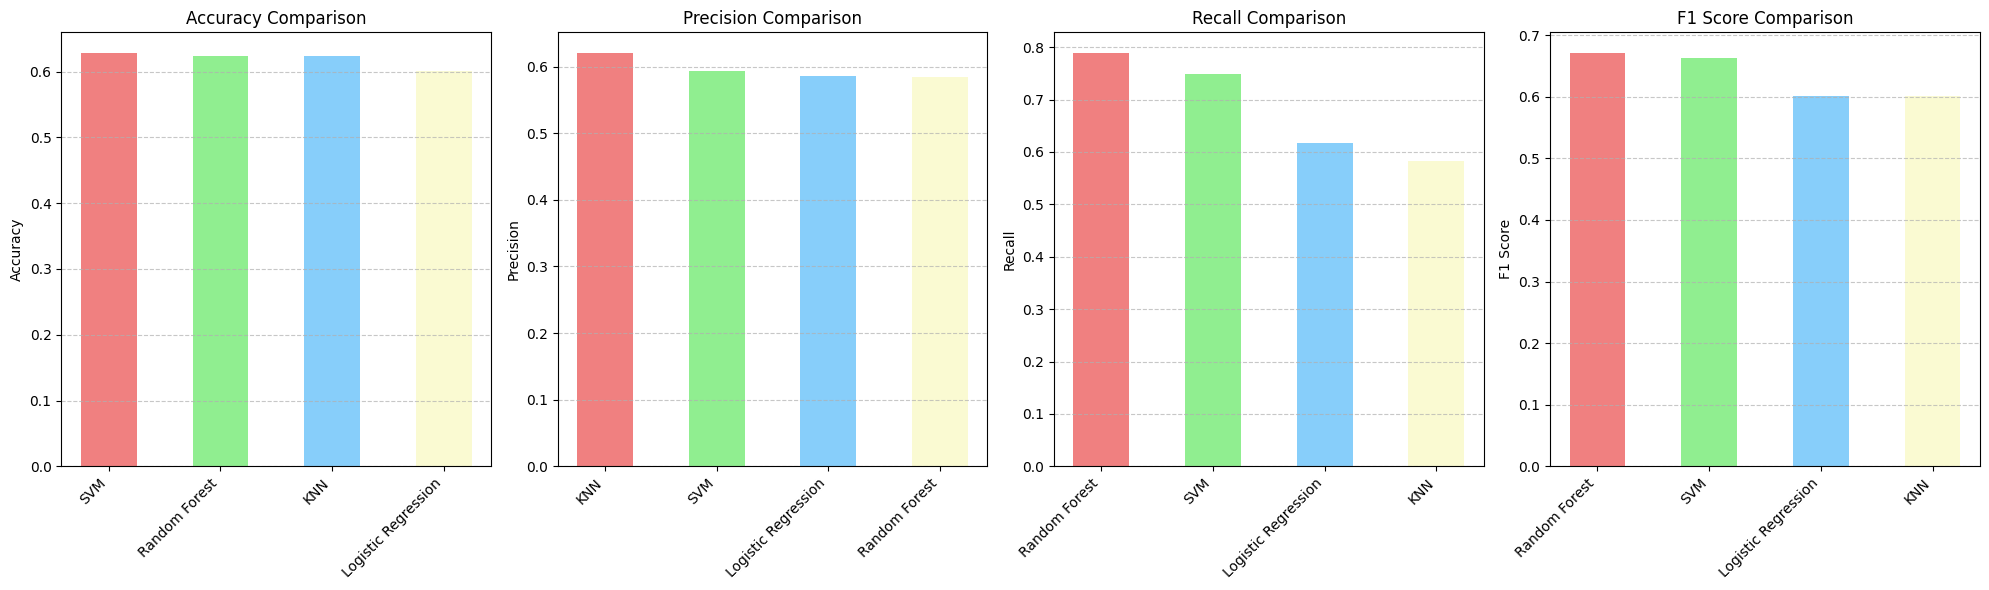

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Store the evaluation metrics for each model
metrics = {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}

models = {'Logistic Regression': lr_model,
          'Random Forest': rf_model,
          'KNN': knn_model,
          'SVM': svm_model}

for name, model in models.items():
    # Predict on the test set
    y_test_pred = model.predict(X_test_combined)

    # Compute performance metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    # Append the results to the corresponding lists
    metrics['Accuracy'].append(accuracy)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    metrics['F1 Score'].append(f1)

x = range(len(models))

# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 6))

# Define colors for the models
model_colors = ['lightcoral', 'lightgreen', 'lightskyblue', 'lightgoldenrodyellow']

# Plot each metric
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
for idx, metric in enumerate(metrics_names):
    # Sort the models by the metric values to make the differences more pronounced
    sorted_metrics = sorted(zip(metrics[metric], list(models.keys())), reverse=True)
    sorted_values, sorted_labels = zip(*sorted_metrics)

    # Plot bars with adjusted width and sorted order
    axes[idx].bar(sorted_labels, sorted_values, color=model_colors[:len(sorted_labels)], width=0.5)
    axes[idx].set_title(f'{metric} Comparison')
    axes[idx].set_ylabel(f'{metric}')
    axes[idx].set_xticklabels(sorted_labels, rotation=45, ha='right')
    axes[idx].grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


## Step 9 : Trying CNN Machine Learning Algorithm

A convolutional neural network (CNN) is a category of machine learning model, namely a type of deep learning algorithm well suited to analyzing visual data.

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models

# Normalize image data
X_train = X_train / 255.0
X_test = X_test / 255.0
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=2)

# Build the CNN model
def build_cnn_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(2, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),  # Adjust learning rate
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create the model
cnn_model = build_cnn_model()

# Train the model
cnn_model.fit(X_train[..., np.newaxis], y_train_cat, epochs=20, batch_size=32,
              validation_data=(X_test[..., np.newaxis], y_test_cat))

# Evaluate the model
test_loss, test_accuracy = cnn_model.evaluate(X_test[..., np.newaxis], y_test_cat)
print(f"Test Accuracy: {test_accuracy:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.5249 - loss: 1.2425 - val_accuracy: 0.5134 - val_loss: 1.1031
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.6847 - loss: 0.5826 - val_accuracy: 0.5134 - val_loss: 1.3861
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.7402 - loss: 0.5152 - val_accuracy: 0.5134 - val_loss: 1.9453
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.7980 - loss: 0.4357 - val_accuracy: 0.5134 - val_loss: 1.3482
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.8143 - loss: 0.4037 - val_accuracy: 0.5330 - val_loss: 0.7639
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.8856 - loss: 0.2871 - val_accuracy: 0.5501 - val_loss: 0.9471
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9019 - loss: 0.2587 - val_accuracy: 0.5086 - val_loss: 1.0704
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.9201 - loss: 0.2131 - val_accuracy: 0.5037 - val_lo

## Step 10 : Conclusion

In this project, we compared the performance of several machine learning models—Logistic Regression (LR), Random Forest (RF), k-Nearest Neighbors (KNN), Support Vector Machine (SVM), and Convolutional Neural Networks (CNN)—for distinguishing real and fake face images. SVM achieved the highest accuracy among traditional models at 63%, while CNN slightly outperformed it with an approximation of 64% accuracy. These results highlight that while traditional models like SVM provide decent performance, deep learning models such as CNNs are more effective for image classification tasks like face detection.